# TinyTimeMixer (TTM) with Exogenous Infusion for predicting Venice tide levels

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for predicting Venetian Lagoon tide levels using exogenous variables. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-1024-96 model. That means the TTM model can take an input of 1024 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Fine-tune*: The pre-trained TTM will be quickly fine-tuned onthe `train` split of the target data, and subsequently, evaluated on the `test` part of the target data. During finetuing, we used the future values mentioned in `control_columns` as exogenous features for modelling. Search for `# exog:` keyword for important parameters to edit for exogenous infusion.

Note: Alternatively, this notebook can be modified to try the TTM-512-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

## Installation

In [1]:
# Install the tsfm library
!pip install "tsfm_public[notebooks] @ git+https://git@github.com/ibm-granite/granite-tsfm.git"
!pip install accelerate==0.34.2

  Cloning https://****@github.com/ibm-granite/granite-tsfm.git to /tmp/wsuser/pip-install-wciewkra/tsfm-public_b82178f2199c4d15afcf098625b40bbc
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/ibm-granite/granite-tsfm.git' /tmp/wsuser/pip-install-wciewkra/tsfm-public_b82178f2199c4d15afcf098625b40bbc
  Resolved https://****@github.com/ibm-granite/granite-tsfm.git to commit 98730fd191ac20bdf26ec42df3dabb85533b1f17
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## Imports

In [3]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

2024-12-09 11:10:01.102386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 11:10:01.102417: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 11:10:01.102423: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Important arguments

In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "venice"
DATA_ROOT_PATH = "datasets/venice/venice_small.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

# Forecasting parameters
context_length = 1024
forecast_length = 96

## Data processing pipeline

In [5]:
# Load the data file and see the columns

timestamp_column = "DATE"
# timestamp_column = "timestamp"
id_columns = []

credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-aae142cb-ae50-4cd6-b376-e90254ca5184',
    'IBM_API_KEY_ID': 'zpGcNA0H7O0EdpMUt4BOXGgrdWy5pBc5Y-1a2c2Wv5rD',
    'ENDPOINT': 'https://s3.direct.us-south.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/identity/token',
    'BUCKET': 'ttmv3-donotdelete-pr-kh9g4dmwg9twty',
    'FILE': 'venice_small.csv'
}

from botocore.client import Config
import ibm_boto3
cos_client = ibm_boto3.client(service_name='s3',
        ibm_api_key_id=credentials['IBM_API_KEY_ID'],
        ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
        ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
        config=Config(signature_version='oauth'),
        endpoint_url=credentials['ENDPOINT'])

bucket = credentials['BUCKET']
object_key = credentials['FILE']

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    
data = pd.read_csv(body, parse_dates=[timestamp_column])
print(data[0:10])


# Selecting exogenous variables as control columns
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": ["LEVEL"],
    "control_columns": [
        "PRESS",
        "RAIN",
        "TEMP",
        "WDIR",
        "WSPEED"
    ],
}

split_params = {"train": [0, 0.5], "valid": [0.5, 0.75], "test": [0.75, 1.0]}

   Unnamed: 0                DATE  LEVEL   PRESS  RAIN  TEMP   WDIR  WSPEED
0           0 2020-01-01 00:00:00   28.0  1030.8   0.0   6.6  308.0     3.2
1           1 2020-01-01 01:00:00   37.0  1031.3   0.0   7.0  341.0     3.9
2           2 2020-01-01 02:00:00   42.0  1031.2   0.0   6.8  343.0     2.8
3           3 2020-01-01 03:00:00   44.0  1031.1   0.0   6.9  326.0     2.4
4           4 2020-01-01 04:00:00   43.0  1031.1   0.0   6.9  346.0     4.1
5           5 2020-01-01 05:00:00   37.0  1031.2   0.0   6.6  350.0     3.7
6           6 2020-01-01 06:00:00   31.0  1031.3   0.0   7.0  347.0     2.7
7           7 2020-01-01 07:00:00   28.0  1031.6   0.0   6.7  337.0     2.3
8           8 2020-01-01 08:00:00   30.0  1031.9   0.0   6.0  339.0     2.9
9           9 2020-01-01 09:00:00   30.0  1032.8   0.0   6.1  344.0     3.0


In [6]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    data,
    split_params,
)

## Zero-shot evaluation method

In [7]:
zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)

INFO:p-6423:t-140587651319616:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-6423:t-140587651319616:get_model.py:get_model:Selected TTM `prediction_length` = 96
INFO:p-6423:t-140587651319616:get_model.py:get_model:Model loaded successfully!
INFO:p-6423:t-140587651319616:get_model.py:get_model:[TTM] context_len = 1024, forecast_len = 96


In [8]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)

In [9]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.548221230506897,
 'eval_model_preparation_time': 0.0053,
 'eval_runtime': 1.2042,
 'eval_samples_per_second': 3093.341,
 'eval_steps_per_second': 48.995}

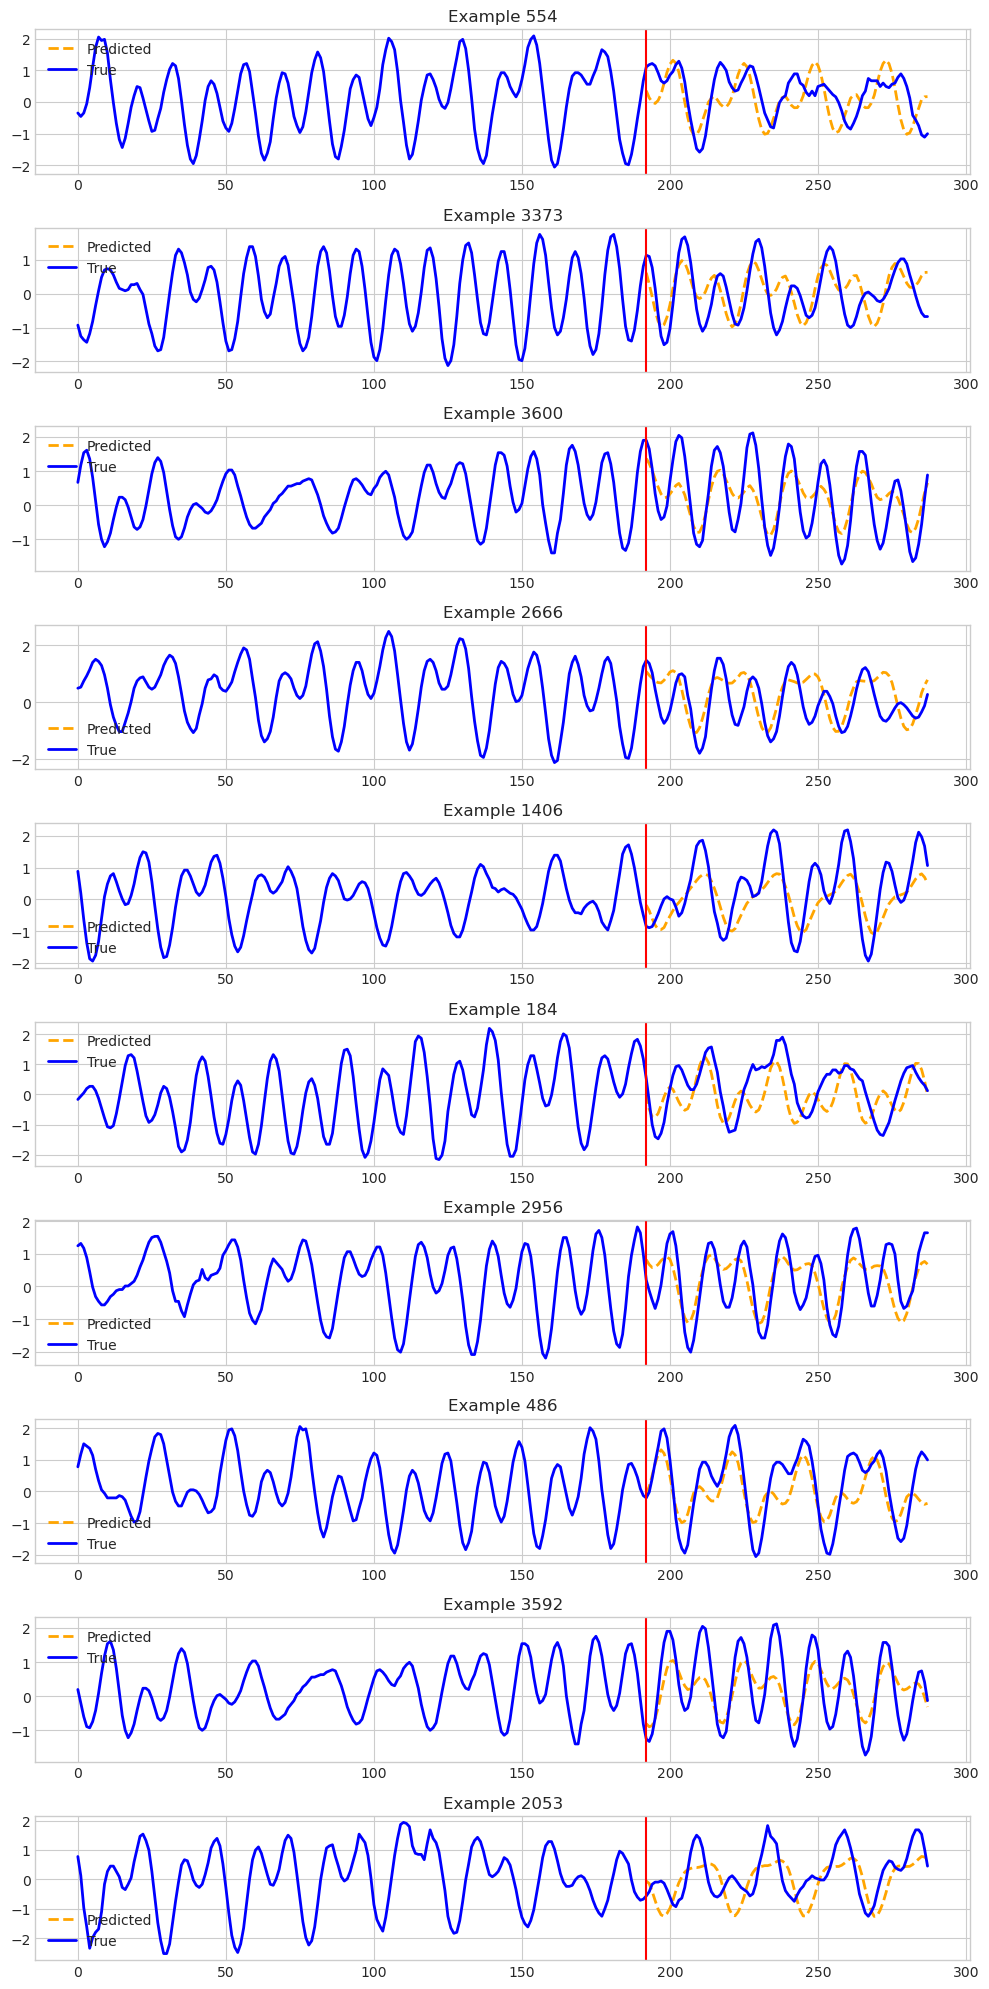

In [ ]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_zeroshot",
    channel=0,
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [11]:
finetune_forecast_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # exog:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_context_length=1,  # exog: indicates lag length to use in the exog fusion. for Ex. if today sales can get affected by discount on +/- 2 days, mention 2
    fcm_use_mixer=True,  # exog: Try true (1st option) or false
    fcm_mix_layers=2,  # exog: Number of layers for exog mixing
    enable_forecast_channel_mixing=True,  # exog: set true for exog mixing
    fcm_prepend_past=True,  # exog: set true to include lag from history during exog infusion.
)

INFO:p-6423:t-140587651319616:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-6423:t-140587651319616:get_model.py:get_model:Selected TTM `prediction_length` = 96
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_fea

### Frezze the TTM backbone

In [12]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 2968649
Number of params after freezing the backbone 959113


### Finetune model with decoder mixing and exog fusion

In [13]:
# Important parameters


# learning_rate = 0.000298364724028334
num_epochs = 50  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

learning_rate, finetune_forecast_model = optimal_lr_finder(
    finetune_forecast_model,
    train_dataset,
    batch_size=batch_size,
    enable_prefix_tuning=False,
)
print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

INFO:p-6423:t-140587651319616:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-6423:t-140587651319616:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.
INFO:p-6423:t-140587651319616:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.0002477076355991711


OPTIMAL SUGGESTED LEARNING RATE = 0.0002477076355991711


In [14]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.0002477076355991711


Epoch,Training Loss,Validation Loss
1,0.659800,0.691441
2,0.502700,0.522107
3,0.330500,0.403964
4,0.253100,0.377197
5,0.223500,0.363166
6,0.200900,0.345008
7,0.182400,0.332633
8,0.161500,0.299877
9,0.129000,0.235600
10,0.104700,0.219386


[TrackingCallback] Mean Epoch Time = 4.311683290144977 seconds, Total Train Time = 186.19783902168274


TrainOutput(global_step=3468, training_loss=0.12393460306741787, metrics={'train_runtime': 186.1983, 'train_samples_per_second': 1750.821, 'train_steps_per_second': 27.39, 'total_flos': 2.425983382683648e+16, 'train_loss': 0.12393460306741787, 'epoch': 34.0})

In [15]:
finetune_forecast_trainer.evaluate(test_dataset)

{'eval_loss': 0.05385742709040642,
 'eval_runtime': 1.0902,
 'eval_samples_per_second': 3416.844,
 'eval_steps_per_second': 54.119,
 'epoch': 34.0}

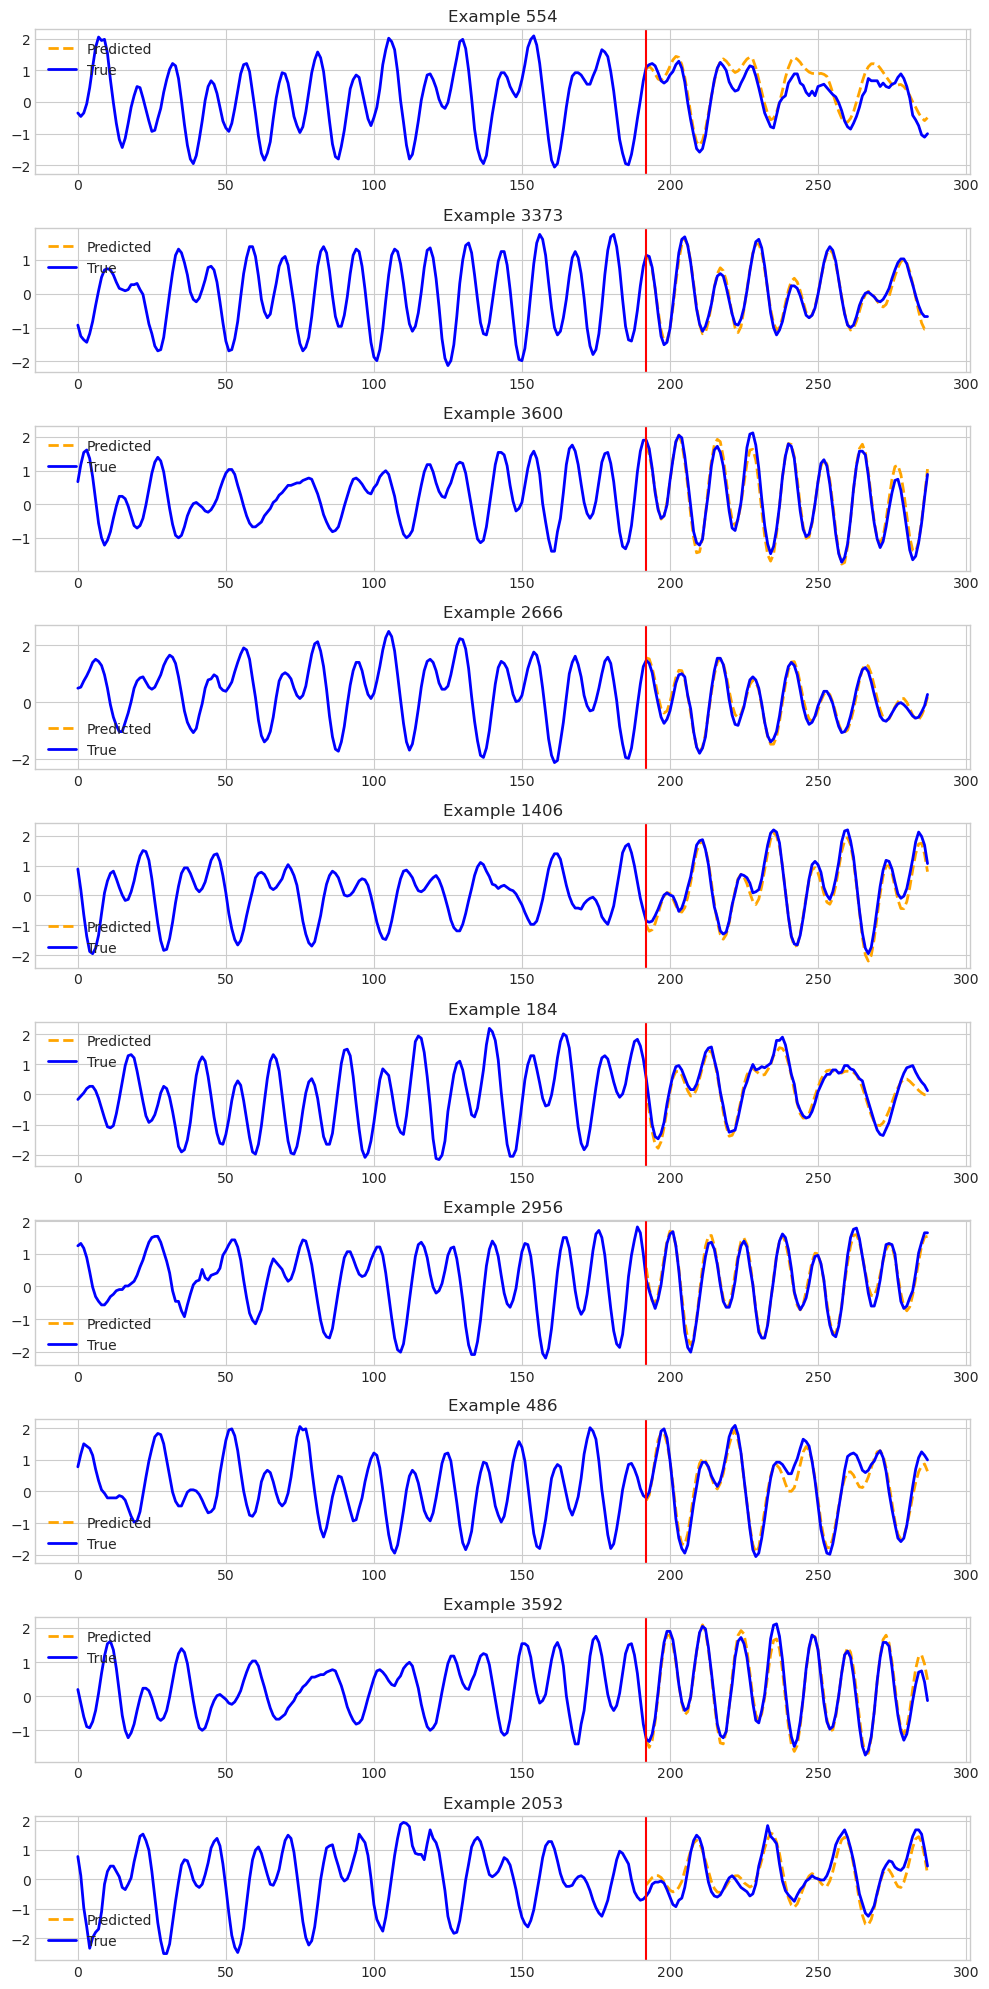

In [ ]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_finetune",
    channel=0,
)